# Individual EOF analysis of SST, SSS and mlt

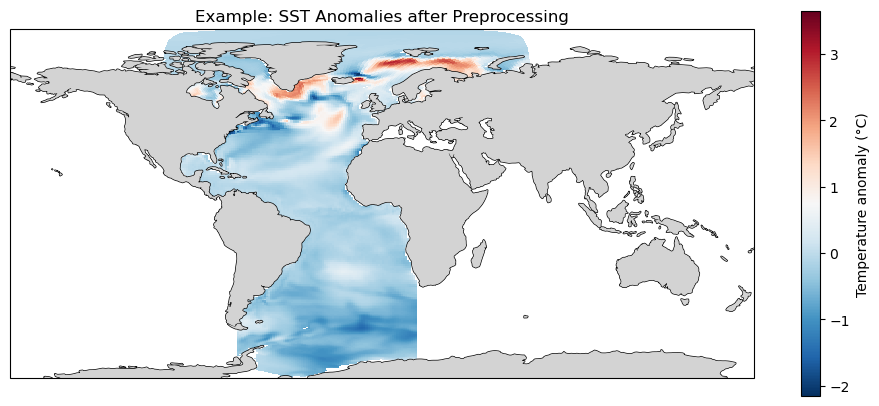

In [17]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load data
# -----------------------------
thetao_path = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc"
so_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc"

thetao = xr.open_dataset(thetao_path)["thetao"]   # 3D temperature [time, lev, j, i]
so = xr.open_dataset(so_path)["so"]               # 3D salinity [time, lev, j, i]

# -----------------------------
# 2. Extract surface layers (lev = 0)
# -----------------------------
sst = thetao.isel(lev=0)  # Sea Surface Temperature
sss = so.isel(lev=0)      # Sea Surface Salinity

# -----------------------------
# 3. Compute anomalies (remove time mean)
# -----------------------------
sst_anom = sst - sst.mean(dim='time')
sss_anom = sss - sss.mean(dim='time')

# -----------------------------
# 4. Compute cosine-latitude weights
# -----------------------------
lat = sst["latitude"]
weights = np.sqrt(np.cos(np.deg2rad(lat)))

# -----------------------------
# 5. Plot example: SST anomalies (first timestep)
# -----------------------------
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("Example: SST Anomalies after Preprocessing")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)

pcm = ax.pcolormesh(
    sst["longitude"], sst["latitude"], sst_anom.isel(time=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="Temperature anomaly (°C)")
plt.show()

# save plot as png
# plt.savefig('example_sst_anomalies.png', dpi=300)

Variance explained by first 3 EOFs:
SST: [45.64977  10.584513  5.334278]
SSS: [26.017014  9.965987  6.661688]
MLT: [29.18344  13.51998   7.189086]


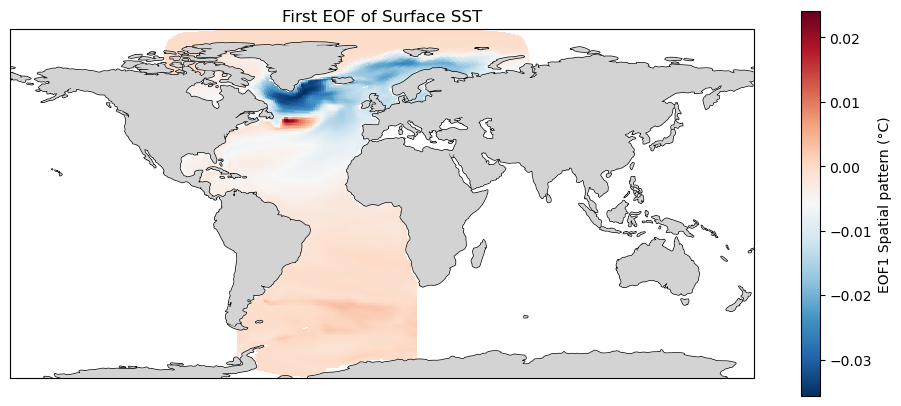

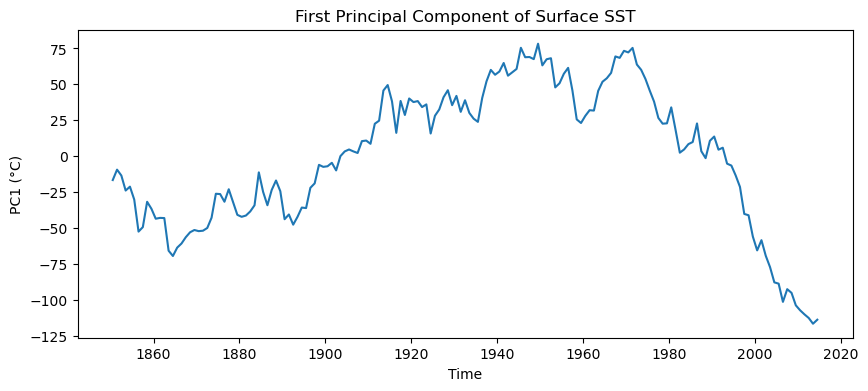

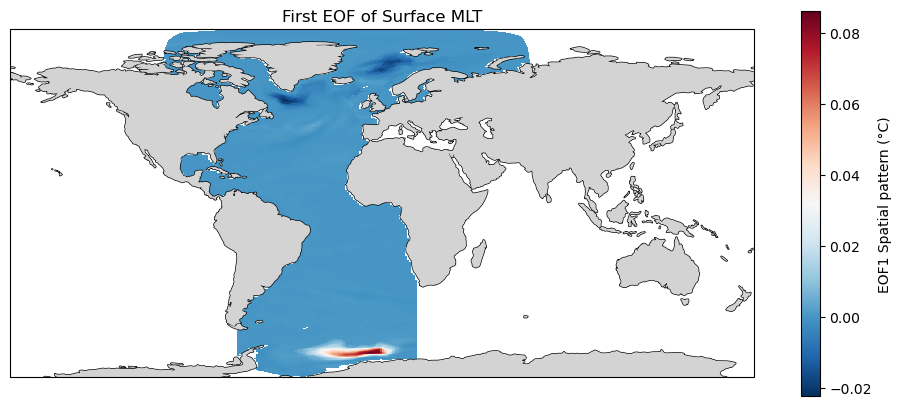

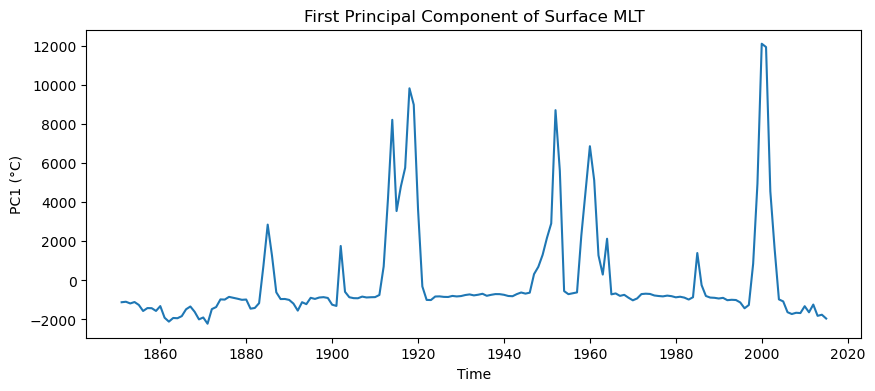

In [18]:
# ==============================================================
# 6. EOF analysis and correlation with AMOC
# ==============================================================

from eofs.xarray import Eof
from scipy.stats import pearsonr
import xarray as xr
import matplotlib.pyplot as plt

# sst_anom, sss_anom, weights are already defined

# -----------------------------
# 1. Load MLT data
# -----------------------------
mlt_path = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc"
mlt = xr.open_dataset(mlt_path)["mlotst"]

# Extract surface/near-surface layer if needed (depends on data shape)
# For mixed layer thickness it might already be 2D (time, lat, lon)
mlt_anom = mlt - mlt.mean(dim='time')  # anomalies

# -----------------------------
# 1. Function to compute EOFs and PCs
# -----------------------------
def compute_eofs(data, weights, n_modes=3):
    solver = Eof(data, weights=weights)
    eofs = solver.eofs(neofs=n_modes)
    pcs = solver.pcs(npcs=n_modes)
    variance = solver.varianceFraction(neigs=n_modes)
    return eofs, pcs, variance

# -----------------------------
# 2. Compute EOFs
# -----------------------------
eofs_sst, pcs_sst, var_sst = compute_eofs(sst_anom, weights)
eofs_sss, pcs_sss, var_sss = compute_eofs(sss_anom, weights)
eofs_mlt, pcs_mlt, var_mlt = compute_eofs(mlt_anom, weights)

# -----------------------------
# 5. Plot EOFs and PCs
# -----------------------------
def plot_eofs_pcs(eofs, pcs, variance, varname):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    for i in range(3):
        # EOF spatial pattern
        im = eofs[i].plot(ax=axes[i, 0], cmap='RdBu_r', add_colorbar=True)
        axes[i, 0].set_title(f'{varname} EOF {i+1} ({variance[i].values*100:.1f}% var)')

        # PC time series
        pcs[:, i].plot(ax=axes[i, 1])
        axes[i, 1].set_title(f'{varname} PC {i+1}')
    plt.tight_layout()
    # plt.show()

# plot_eofs_pcs(eofs_sst, pcs_sst, var_sst, 'SST')
# plot_eofs_pcs(eofs_sss, pcs_sss, var_sss, 'SSS')

# print variance explained
print("Variance explained by first 3 EOFs:")
print("SST:", var_sst[:3].values * 100)
print("SSS:", var_sss[:3].values * 100)
print("MLT:", var_mlt[:3].values * 100)

# Plot first EOF with cartopy
fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title("First EOF of Surface SST")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)

pcm = ax.pcolormesh(
    sst["longitude"], sst["latitude"], eofs_sst.isel(mode=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="EOF1 Spatial pattern (°C)")
plt.show()

# plot first PC
plt.figure(figsize=(10,4))
pc1 = pcs_sst.isel(mode=0)
pc1.plot()
plt.title('First Principal Component of Surface SST')
plt.xlabel('Time')
plt.ylabel('PC1 (°C)')
plt.show()

# Plot first EOF and PC of MLT with cartopy

fig = plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("First EOF of Surface MLT")
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
pcm = ax.pcolormesh(
    mlt["longitude"], mlt["latitude"], eofs_mlt.isel(mode=0),
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    shading="auto"
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label="EOF1 Spatial pattern (°C)")
plt.show()

plt.figure(figsize=(10,4))
pc1 = pcs_mlt.isel(mode=0)
pc1.plot()
plt.title('First Principal Component of Surface MLT')
plt.xlabel('Time')
plt.ylabel('PC1 (°C)')
plt.show()


In [19]:
# -----------------------------
# 3. Load AMOC index
# -----------------------------
amoc_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
amoc = xr.open_dataset(amoc_path)["msftyz"]
amoc_index = amoc.mean(dim=('latitude', 'depth'))  # Adjust dimensions if needed

# -----------------------------
# 4. Correlate PCs with AMOC
# -----------------------------
def correlate_pcs_with_amoc(pcs, amoc_index):
    correlations = []
    for i in range(pcs.shape[1]):
        r, _ = pearsonr(pcs[:, i], amoc_index)
        correlations.append(r)
    return correlations

corr_sst = correlate_pcs_with_amoc(pcs_sst.values, amoc_index.values)
corr_sss = correlate_pcs_with_amoc(pcs_sss.values, amoc_index.values)
corr_mlt = correlate_pcs_with_amoc(pcs_mlt.values, amoc_index.values)

print("Correlation with AMOC (SST PCs):", corr_sst)
print("Correlation with AMOC (SSS PCs):", corr_sss)
print("Correlation with AMOC (MLT PCs):", corr_mlt)




ValueError: 'latitude' not found in array dimensions ('time', 'basin', 'lev', 'rlat')

# Combined EOF analysis

In [ ]:
# -------------------------------------------------------------
# 1. Combine SST, SSS, and MLT into a single dataset
# -------------------------------------------------------------
import xarray as xr
import numpy as np

# Interpolate MLT to match SST time dimension
mlt_anom = mlt_anom.interp(time=sst_anom.time)

# Ensure all variables have matching grid/time dimensions
sst_anom, sss_anom, mlt_anom = xr.align(sst_anom, sss_anom, mlt_anom)

# Stack spatial dimensions into one (like flattening maps)
sst_flat = sst_anom.stack(points=("j", "i"))
sss_flat = sss_anom.stack(points=("j", "i"))
mlt_flat = mlt_anom.stack(points=("j", "i"))

# Standardize each variable (optional but highly recommended)
# so that SST, SSS, and MLT contribute equally
sst_std = (sst_flat - sst_flat.mean()) / sst_flat.std()
sss_std = (sss_flat - sss_flat.mean()) / sss_flat.std()
mlt_std = (mlt_flat - mlt_flat.mean()) / mlt_flat.std()

# Combine along a new "variable" dimension
combined = xr.concat([sst_std, sss_std, mlt_std], dim="variable")
combined["variable"] = ["SST", "SSS", "MLT"]

# The data now has shape: (variable, time, points)
print(combined.shape)



(3, 165, 105704)


In [22]:
import xarray as xr
from eofs.xarray import Eof

# --- Align and combine datasets ---
sst_anom, sss_anom, mlt_anom = xr.align(sst_anom, sss_anom, mlt_anom, join="inner")

# --- Flatten spatial dimensions for each variable ---
def flatten_field(da):
    # Reset any existing multi-index before stacking
    da = da.reset_index(da.dims, drop=False)
    return da.stack(points=("lat", "lon"))

sst_flat = flatten_field(sst_anom)
sss_flat = flatten_field(sss_anom)
mlt_flat = flatten_field(mlt_anom)

# --- Combine into one dataset ---
combined = xr.concat([sst_flat, sss_flat, mlt_flat], dim="variable")
combined["variable"] = ["SST", "SSS", "MLT"]

# --- Transpose and stack properly ---
combined_2d = combined.transpose("time", "variable", "points")

# Now merge variable + spatial dimensions into a single one
combined_2d = combined_2d.stack(space=("variable", "points"))

# --- EOF analysis ---
solver = Eof(combined_2d)

eofs = solver.eofs(neofs=3)
pcs = solver.pcs(npcs=3)

print("EOFs shape:", eofs.shape)
print("PCs shape:", pcs.shape)



KeyError: 'lat'